# Exploration of 1-D Hubbard models usign discrete DMC#

### Abstract ###

In this notebook I test the discretized propagtor of the grid DMC for a series of simple Hubbard models in one dimension

Hubbard model is defined by the following Hamiltonian:

$$
\hat{H} = -t \sum_{i,s=\pm1} \{a^{\dagger}_{i+1,s}a_{i,s} + a^{\dagger}_{i,s}a_{i+1,s} \} + U \sum_i n_{i,1}n_{i,-1},
$$

where i the lattice site index running over the range from 1 to the number of lattice sites N, i.e. $i =1, \dots, N$. If the boundary condition is applied for a finite N the number of points in the Brilouin zone will be exactly N. In the following examples we examine the propagator for both finite and infinite values of N. If $U = 0$, the problem can be solved exactly giving the following dispersion relation for both spin projections:


$$
\epsilon(k) = -2t\cos(k).
$$



## Kinetic energy propagator

For the case of the infinite Hubbard chain with $U = 0$ and $N \to \infty$

$$ p_d = \frac{1}{2\pi} \int_{ -\pi}^{\pi} \cos(k d) e^{2\tau t\cos(k)} dk, $$
where $t \ge 0$ is the hopping parameter and $\tau$ is the imaginary time step. In the next snippet I calculate $p_d$ for a series of $d$ parameters and some typical values of $\tau$ and $t$.

In [32]:
import numpy as np
from scipy.integrate import quad

In [33]:
def kernel_H(k, t_, tau_):
    return 0.5 * np.exp(2. * t_ * tau_ * np.cos(k)) / np.pi

def pd_H(t, tau):
    thresh = 1e-8
    disp = [0]
    pd = []
    
    terminate = False
    while not terminate:
        d = disp[-1]
        r = quad(kernel_H, -np.pi, np.pi, (t, tau), weight='cos', wvar=d, epsabs=thresh/100.,epsrel=1e-3)
        if r[1] > max(thresh/100., r[0] * 1e-3):
                print("WARNING! Insufficient integration accuracy for displacement {0}!\n".format(r[1]))
                
        pd.append(r[0])
        if abs(r[0]) < thresh:
            terminate = True
        else:
            disp.append(d + 1)
                
    pd = np.array(pd[-1:0:-1] + pd)
    disp = np.array([-disp[j] for j in range(len(disp) - 1, 0, -1)] + disp)
    
    return (pd, disp)
        

In [34]:
t = 5.
tau = 0.1
pd, disp = pd_H(t, tau)

In [35]:
print(pd)

[5.51838593e-09 9.96062403e-08 1.59921823e-06 2.24886615e-05
 2.71463156e-04 2.73712022e-03 2.21684249e-02 1.35747670e-01
 5.65159104e-01 1.26606588e+00 5.65159104e-01 1.35747670e-01
 2.21684249e-02 2.73712022e-03 2.71463156e-04 2.24886615e-05
 1.59921823e-06 9.96062403e-08 5.51838593e-09]


In [36]:
from matplotlib import pyplot as plt

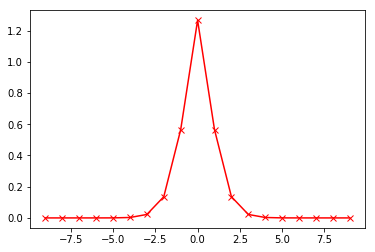

In [38]:
plt.plot(disp, pd, 'rx-')

The above graph shows that the propagator is positive across the whole range of hopping distances.

If $N$ is finite the popagator can be calculated as follows:

$$
p_d = \frac{1}{N} \sum_{l = 0}^{N - 1} \cos\Big(\frac{2\pi l}{N} d\Big) e^{2\tau t\cos(\frac{2\pi l}{N})}
$$

In [49]:
def pd_H_fin(t, tau, N):
    disp = [ i for i in range(-int(N/2), int(N/2))]
    pd = []
        
    for d in disp:
        
        k = np.arange(N) * 2. * np.pi / N
        p = 1./ N * np.dot(np.cos(k * d),  np.exp(2. * t * tau * np.cos(k)))
        pd.append(p)
       
                
    return (pd, disp)  

In [56]:
N = 20
pd, disp = pd_H_fin(t, tau, N)

In [57]:
print(len(pd))

20


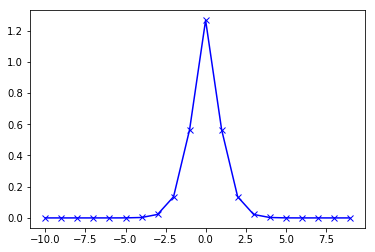

In [58]:
plt.plot(disp, pd, 'bx-')

In [ ]:
class Hubbard_H:
    
    def __init__(self, Ns, Ne, Sz):
        from itertools import combinations
        self.Ns = Ns              # Number of sites
        self.Na = (Ne + 2*Sz) / 2 # Number of alpha electrons
        self.Nb = (Ne - 2*Sz) / 2 # Number of beta electrons
        self.alpha_str = []
        self.beta_str = []
        for a in combinations([i for i in range(self.Ns)], self.Na):
            self.alpha_str.append(a)
        for b in combinations([i for i in range(self.Ns)], self.Nb):
            self.beta_str.append(b)
            
        print("Num. of sites / Num. of electrons: {} / {}".format(self.Ns, self.Na + self.Nb))
        print("Number of alpha strings {:5d}".format(len(alpha_str)))
        print("Number of beta strings {:5d}".format(len(beta_str)))
        
    def build_hamiltonian(self):
        pass
    
    def diagonalize(self):
        pass
        

## Implementation of the quantum Monte-Carlo method ##

**Random_walk** class provided below implements a grid propagator defined by the following expression for the transition probability:

$$ p_d = \frac{1}{2\pi} \int_{ -\pi}^{\pi} \cos(k d) e^{-\frac{2\tau}{\delta^{2}}\sin^2 (k/2)} dk, $$

where d is the length of the step on the 1-D integer lattice ($d = 0, \pm 1, \pm 2, \pm 3,...$), $\tau$ is the timestep of the diffusion random walk, and $\delta$ is a uniform grid spacing. The integral is calculated numerically using a general 1-D quadrature subroutine *quad* from *NumPy* for a series of d such that $p_d < 10^{-8}$ (the default value of thresh). The absolute integration accuracy is set to thresh/100 and the relative accuracy is $10^{-3}$.

In [3]:
# Functor class generating grid displacements

class Random_walk:
        
    
    def __init__(self, delta, tau, thresh = 1e-8):
        
        # The names of the input parameters should be self-explanatory
        
        import numpy as np
        from scipy.integrate import quad
        
        assert delta > 0. and tau > 0.
        self.delta = delta
        self.tau = tau
                
        # Calculate the cumulative probabilites
        disp = [0]
        pd = []
        
        def kernel(k, d, t):
            return 0.5 * np.exp(-2. * t * np.sin(k/2.)**2 / d**2) / np.pi
        
        terminate = False
        while not terminate:
            d = disp[-1]
            r = quad(kernel, -np.pi, np.pi, (self.delta, self.tau), weight='cos', wvar=d, epsabs=thresh/100.,epsrel=1e-3)
            if r[1] > max(thresh/100., r[0] * 1e-3):
                print("WARNING! Insufficient integration accuracy for displacement {0}!\n".format(r[1]))
                
            pd.append(r[0])
            if abs(r[0]) < thresh:
                terminate = True
            else:
                disp.append(d + 1)
                
        self.pd = np.array(pd[-1:0:-1] + pd)
        self.cumm_pd = np.cumsum(self.pd)
        self.disp = np.array([-disp[j] for j in range(len(disp) - 1, 0, -1)] + disp)
        
    def __call__(self, num_samples):
        
        import numpy as np
        
        r = np.random.choice(self.disp, size=num_samples, p=self.pd)
        
        return r
        
         
    def __call_old__(self, num_samples):
        
        import numpy as np
        
        r = np.random.rand(num_samples)
        #print len(r)
        compare_mask = self.cumm_pd[np.newaxis,:] > r[:,np.newaxis]
        #print compare_mask.shape
        return np.array(self.disp[np.argmax(compare_mask, axis=1)])
        

It can be shown that $p_d$ resembles Gaussian distribution in the limit $\delta \to 0$ ($\delta << \sqrt(\tau)$). However, the two may differ significantly if $\delta$ is comparable to $\sqrt(\tau)$ as shown by the following example

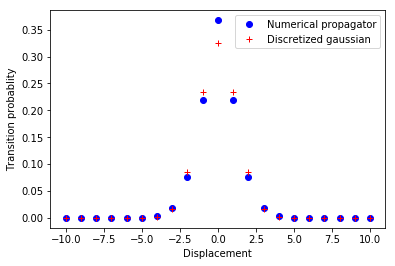

In [39]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

delta = 0.1
tau = 0.015 
rw = Random_walk(delta=delta, tau=tau)
disp = rw.disp
pd = rw.pd
#Discretized Gaussian
pd_gau = delta / np.sqrt(2. * np.pi * tau)  * np.exp(-delta**2 * disp**2 / (2. * tau))

plt.plot(disp, pd, 'bo', label='Numerical propagator')
plt.plot(disp, pd_gau,'r+', label='Discretized gaussian')

plt.xlabel("Displacement")
plt.ylabel("Transition probablity")
plt.legend()

The instances of the **Random_walk** class can be used to generate random walks on integer lattices by invoking the '__call__' method. In order to test the validity of our implementation we generate a series of *n_samples* and demonstrate that their distribution agrees with the analytic result.

Number of sampled displacements 100000


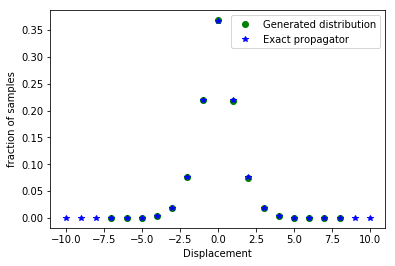

In [41]:
# Check whether the class produces correct displacement statistics
n_samples = 100000
displacements = rw(n_samples)
print("Number of sampled displacements {0}".format(displacements.shape[0]))
assert displacements.shape[0] == n_samples
#print(displacements)

hist = {}
for i in displacements:
    if i in hist:
        hist[i] += 1
    else:
        hist[i] = 1

# Normalize and compare with the exact distribution
plt.plot(hist.keys(), np.array(hist.values())/float(n_samples), 'go', label='Generated distribution')
plt.plot(disp, pd, 'b*', label='Exact propagator')

plt.xlabel("Displacement")
plt.ylabel("fraction of samples")
plt.legend()

**Walker_ensemble** class implements the core of the grid-based quantum Monte-Carlo algorithm. It uses instances of **Random_walk** class to generate diffusion random walks on spatial grids. The imaginary time propagation is executed by invoking a *one_time_step* method which in turn calls *_diffuse_and_branch, _update_phases* and *_annihilate_walkers* methods. The energy is then 'measured' by the growth estimator. The class also provides a functionality to implement constraints which can for example be used to perform fixed-node simulations and impose spatial symmetry. Present code is restricted to 1-D systems.

In [76]:
class Walker_ensemble:
    
    def __init__(self, random_walk, potential, n_walkers, n_alpha, n_beta, constraint=None, pop_dyn=False, S=0.0):
        
        import numpy as np
        from sympy.combinatorics.permutations import Permutation
        import itertools as it
        
        L = 5. # Initial walker population will be (uniformly) distributed in the interval [-L, L]
        
        # Are we performing a regular run or recording population dynamics?
        self.pop_dyn = pop_dyn
        
        # System specification
        self.disp_generator = random_walk # An instance of random walk class
        self.V = potential # A callable python object capable of operating on a walker (=set of particle coordinates)
        self.S = S # initial guess for the growth estimator
        self.apply_constraint = False
        self.constraint = None
        
        if constraint != None:
            self.constraint = constraint # A callable python object capable of operating on a walker and returning True/False
            self.apply_constraint = True
        
        # Walker positions and weights; 
        # The former are expressed by the coordinates on the integer lattice.
        # The latter should ALWAYS be \pm 1!
        self.n_alpha = n_alpha # number of alpha electrons
        self.n_beta = n_beta   # number of beta electrons
        self.lookup_a = {} # all permutations of alpha electrons with corresponding parities
        self.lookup_b = {} # same for beta
        
        pa = it.permutations(np.arange(n_alpha))
        pb = it.permutations(np.arange(n_beta))
        
        for i in pa:
            parity = 1 if Permutation(i).is_even else -1
            self.lookup_a[i] = parity
        for i in pb:
            parity = 1 if Permutation(i).is_even else -1
            self.lookup_b[i] = parity
        
        self.walker_weights = np.ones(n_walkers, dtype=int)
        self.walker_coords = np.zeros((n_walkers, n_alpha + n_beta), dtype=int)
        
        # Timing info for reference purposes
        self.time = {'total': 0.0, 'branching': 0.0, 'phase_update': 0.0, 'annihilation' : 0.0, 'n_steps' : 0}
                
        # Initialize walker ensemble 
        # and make sure that the walkers conform to the Pauli principle and don't violate constraints
        d = self.disp_generator.delta
        grid_init = np.arange(-L/d, L/d + 1, dtype=int)
        kwargs = {'size' : n_alpha, 'replace' : False} # replace = False makes sure that the Pauli principle is not violated
        alpha_coord = np.apply_along_axis(np.random.choice, 1, np.broadcast_to(grid_init, (n_walkers, grid_init.shape[0])), **kwargs)
        alpha_coord = np.apply_along_axis(np.sort, 1, alpha_coord)
        kwargs = {'size' : n_beta, 'replace' : False}
        beta_coord = np.apply_along_axis(np.random.choice, 1, np.broadcast_to(grid_init, (n_walkers, grid_init.shape[0])), **kwargs) 
        beta_coord = np.apply_along_axis(np.sort, 1, beta_coord)
        
        # Check if the coordinates of alpha and beta particles indeed satisfy the Pauli principle
        all_distinct = lambda ar : len(ar) == len(np.unique(ar))
        a = np.apply_along_axis(all_distinct, 1, alpha_coord)
        b = np.apply_along_axis(all_distinct, 1, beta_coord)
        
        if self.apply_constraint:
            constr_a = np.apply_along_axis(self.constraint, 1, alpha_coord)
            constr_b = np.apply_along_axis(self.constraint, 1, beta_coord)
            a = np.logical_and(a, constr_a)
            b = np.logical_and(b, constr_b)
            
        
        alpha_ok = True if n_alpha == 0 else np.all(a)
        beta_ok = True if n_beta == 0 else np.all(b)
        
        assert alpha_ok and beta_ok
        
        # Combine the coordinates of alpha and beta electrons (the resulting list may contain duplicates)
        self.walker_coords = np.hstack((alpha_coord, beta_coord))
        
    def one_time_step(self):
        
        # High level grid QMC driver 
        
        import numpy as np
        import time
        
        start = time.clock()
        
        n_walkers_old = self.get_number_of_walkers()
                
        self._diffuse_and_branch()
        
        self.time['branching'] += time.clock() - start
        
        t1 = time.clock()
        
        self._update_phases()
                
        self.time['phase_update'] += time.clock() - t1
        
        t2 = time.clock()
        
        self._annihilate_walkers()
        
        self.time['annihilation'] += time.clock() - t2
        self.time['total'] += time.clock() - start
        self.time['n_steps'] += 1
        
        n_walkers_new = self.get_number_of_walkers()
        #print("Number of walkers at the end of the step is {0}".format(n_walkers_new))
        
        if not self.pop_dyn:
            self.S = self.S + 1./ self.disp_generator.tau * np.log(n_walkers_old/float(n_walkers_new))
    
    def _diffuse_and_branch(self):
        
        import numpy as np
        
        # Perform diffusion displacement
        
        random_walk =  self.disp_generator
        d = self.disp_generator.delta # grid spacing
        t = self.disp_generator.tau   # imaginary time step
        
        # the code snippet below will work correctly only if all weights are \pm 1
        n_walkers = self.get_number_of_walkers()
        assert n_walkers == self.walker_weights.shape[0]
        walker_size = self.n_alpha + self.n_beta
        disp = random_walk(n_walkers*walker_size)
        disp = disp.reshape(n_walkers, walker_size)
        
        # Some displacements give rise to the particles with
        # identical spin labels sitting on top of each other;
        # Those violate the Pauli principle and should be removed
        
        new_walker_coords = self.walker_coords + disp
        new_coords_a, new_coords_b = np.hsplit(new_walker_coords, [self.n_alpha])
        all_distinct = lambda ar : len(ar) == len(np.unique(ar))
        a = np.apply_along_axis(all_distinct, 1, new_coords_a)
        b = np.apply_along_axis(all_distinct, 1, new_coords_b)
        #print(a)
        #print(b)
        alive = np.logical_and(a,b) # positions of alive walkers
        
        # Apply constraints if any
        
        if self.apply_constraint:
            constr_a = np.apply_along_axis(self.constraint, 1, new_coords_a)
            constr_b = np.apply_along_axis(self.constraint, 1, new_coords_b)
            c = np.logical_and(constr_a, constr_b)
            alive = np.logical_and(c, alive)
        
       
        self.walker_coords = np.array(self.walker_coords[alive,:], dtype=int)
        self.walker_weights = np.array(self.walker_weights[alive], dtype=int)
        new_walker_coords = np.array(new_walker_coords[alive,:], dtype=int)
        
        # After this step one may still have all-electron walkers sitting atop of each other
        # but the algorithm is blind to that
        # Perform branching
        # NOTE: only alive walkers are participating in branching
               
        m = np.exp(-0.5 * t * ( np.apply_along_axis(self.V, 1, d*self.walker_coords) + np.apply_along_axis(self.V, 1, d*new_walker_coords) - 2. * self.S))
        r = np.random.rand(m.shape[0])
        
        # Assign integer weights and remove dead walkers
        
        new_walker_weights = np.asarray(m + r, dtype=int) * self.walker_weights
        alive = (new_walker_weights != 0)
        self.walker_coords = np.array(new_walker_coords[alive,:], dtype=int)
        self.walker_weights = np.array(new_walker_weights[alive], dtype=int)
        
        # Some walkers can acquire abs. weights > 1
        # Those clusters need to be separated
        # That will be done after the annihilation step
    
    def _update_phases(self):
        
        import numpy as np
               
        # Update walker signs based on whether the coordinates got interchanged
        # Split alpha and beta subsets first
        
        alpha_coord, beta_coord = np.hsplit(self.walker_coords, [self.n_alpha])
        p_alpha = np.argsort(alpha_coord, axis=1)
        p_beta = np.argsort(beta_coord, axis=1)
        
        parity = lambda p: self.lookup_a[tuple(p)]
        parity_a = np.apply_along_axis(parity, 1, p_alpha)
        parity = lambda p: self.lookup_b[tuple(p)]
        parity_b = np.apply_along_axis(parity, 1, p_beta)
        
        self.walker_weights = self.walker_weights * parity_a * parity_b
        alpha_coord = np.sort(alpha_coord, axis=1)
        beta_coord = np.sort(beta_coord, axis=1)
        
        self.walker_coords = np.hstack((alpha_coord, beta_coord))
        
 
    def _annihilate_walkers(self, catch_collisions=False):
                
        # Find and collect duplicates (perform annihilation)
        # A "quick and dirty" way to accomplish that is to hash
        # the walker coordinates & perform sorting;
                
        converter = lambda a: hash(a.tostring())
        walker_coords_str = np.apply_along_axis(converter, 1, self.walker_coords)
        
        if catch_collisions:
            
            # Check if we have any collisions, i.e. all the hashes are distinct for distinct walkers
            
            unique_hashes = set(walker_coords_str)
            walker_index = np.arange(walker_coords_str.shape[0], dtype=int)
        
            if len(unique_hashes) != len(walker_index):
            
                # Check if there is a collision
                for h in unique_hashes:
                    walkers_with_hash_h = np.array(self.walker_coords[(h == walker_coords_str), :], dtype=int)
                    if len(walkers_with_hash_h) == 1:
                        continue
                    else:
                        assert np.all(walkers_with_hash_h[0][:] == walkers_with_hash_h) # broadcasted!
        
            
        unique_walkers_str_, idx = np.unique(walker_coords_str, return_index = True)
        combined_weights = []
        
        for i in idx:
            idx_duplicates = (walker_coords_str[i] == walker_coords_str)
            combined_weights.append(np.sum(self.walker_weights[idx_duplicates]))
            
        self.walker_coords = np.array(self.walker_coords[idx, :], dtype=int)
        self.walker_weights = np.array(combined_weights, dtype=int)
        
        self._expand()
    
    def _expand(self):
        
        # Simplified version of expand function
        # implemented without using fancy NumPy features
                
        n = self.walker_weights.shape[0]
        split_weights = []
        split_coords = []
        
        for i in range(n):
            num_of_instances = abs(self.walker_weights[i])
            sign = 1 if self.walker_weights[i] > 0 else -1
            for j in range(num_of_instances):
                split_weights.append(sign)
                split_coords.append(self.walker_coords[i, :])
        
        self.walker_coords = np.vstack(tuple(split_coords))
        self.walker_weights = np.array(split_weights, dtype=int)
        
    def get_number_of_walkers(self):
        import numpy as np
        return np.sum(np.abs(self.walker_weights))
    
    def get_energy(self):
        return self.S
  

## Applications ##

### Fermions in harmonic trap ###

Non-interacting fermions in harmonic trap provide a convenient test case for the algorithm of the previous section for the following reasons:

1. Numerically exact energies for finite (non-zero) grid spacings can be readily calculated as sums of one-particle eigenvalues.
2. The fermions are confined by soft non-divergent potential so that the branching factors in QMC are always finite.

In the following we will assume that the potential energy oprator is $V = \frac{1}{2} \sum_{i=1}^{N_e} x_i^{2}$ and consider the cases where $N_e = 1, 2, 3$ and $4$

In [42]:
def V_harm(x):
    return 0.5 * np.sum(x**2)

### Case $N_e = 1$ ###

As a first step, we determine the reference energies of one-particle states via direct diagonalization of the Hamiltonian obtained by approximating the kinetic energy operator using a three point finite difference  formula on a **uniform** grid with sapcing $\delta = 0.1$ a.u. spanning the interval $[-L, L]$:

$$ \hat{T}\psi(x_i) = \frac{2\psi(x_i) - \psi(x_{i + 1}) - \psi(x_{i - 1})}{2\delta^{2}}, $$

where $x_{i\pm1} = x_i \pm \delta$. Scince our goal is to approximate the solutions of the stationary Shrodinger equation for $L \to +\infty$ we perform a series of diagonalizations for increasing $L$ requiring that the energies of a selected subset of low-lying states have **at least 6 digits of accuracy**. The calculations are performed assuming the boundary condition $\psi(L) = \psi(-L) = 0$.

In [43]:
from numpy import linalg as LA

def construct_H(L, delta):
    # Input:
    # L     - grid span
    # delta - grid spacing 
    # Output:
    # $H_{\delta}$ - matrix of the discretized Hamiltonian
    x = np.linspace(-L, L, int(2. * L / delta) + 1) # grid points
    V = np.diag(0.5 * x**2)                        # potential energy
    T = -1./ (2. * delta**2) * ( np.eye(len(x), k = 1) - 2. * np.eye(len(x)) + np.eye(len(x), k =-1) ) # kinetic energy
    return T + V

delta = 0.1
L = 4. # Initial grid span
eps = 1e-6
converged = False
e5 = np.zeros(5)

while not converged:
    H = construct_H(L, delta)
    e = LA.eigvalsh(H)
    e5_new = np.array(e[0:5])
    if max(abs(e5_new - e5)) < eps:
        converged = True
    else:
        L *= 2.
    
    e5 = np.copy(e5_new)

print("Energies of harmonic oscillator states on a uniform grid with spacing {0}".format(delta))
print(e5)

Energies of harmonic oscillator states on a uniform grid with spacing 0.1
[ 0.4996873   1.49843574  2.49593063  3.49216962  4.48715031]


Alternatively, the ground state of the 1-D harmonic oscillator can be sampled using quantum Monte-Carlo scheme:

In [47]:
rw0101 = Random_walk(delta=0.1, tau=0.1) # define a new random walk on a grid with spacing delta = 0.1 and tau = 0.1
D1 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=2000, n_alpha=1, n_beta=0, S=0.5)

N_equil = 500
N_prod = 2048
E = np.zeros(N_prod)
N = np.zeros(N_prod)

#Perform N_equil equilibration steps
for i in range(N_equil):
    D1.one_time_step()

print("Number of walkers at the end of equilibration run is {0}".format(D1.get_number_of_walkers()))
print("Starting production run...")

for i in range(N_prod):
    D1.one_time_step()
    E[i] = D1.get_energy()
    N[i] = D1.get_number_of_walkers()
    
print("Average energy at the end of the production run: {0:13.6f}".format(np.mean(E)))
    


Number of walkers at the end of equilibration run is 2004
Starting production run...
Average energy at the end of the production run:      0.500943


In order to calculate statistical errors of the energy estimators we used blocking algorithm as described in [H.Flyvbjerg et al. *J. Chem. Phys.* 91, 461 (1989)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwiBjaaf68ndAhXH6YMKHSuyCdgQFjAAegQIBBAB&url=https%3A%2F%2Faip.scitation.org%2Fdoi%2F10.1063%2F1.457480&usg=AOvVaw0DEeYW79PHKKZfPb61xsKZ). The notebook relies on the python implementation of the bloking analysis due to J.Spencer which is freely available from the Github page [pyblock](https://github.com/jsspencer/pyblock)

In [48]:
pyblock_is_installed = True
try:
    import pyblock as pb
except ImportError as e:
    print("PyBlock was not found! The error estimates will not be available.")
    pyblock_is_installed = False
    

In [57]:
# If PyBlock is found we can proceed to calculate statistical errors
if pyblock_is_installed:
    reblock_data = pb.blocking.reblock(E)
    opt = pb.blocking.find_optimal_block(len(E), reblock_data)
    print("Optimal block: {}".format(opt))
    print(reblock_data[opt[0]])
    print("< E > = {0:10.6f} +- {1:10.6f}".format(float(reblock_data[opt[0]][2]), float(reblock_data[opt[0]][4])))

Optimal block: [5]
BlockTuple(block=5, ndata=64, mean=array(0.5009431527081165), cov=array(0.00014861497030582347), std_err=array(0.0015238467478813254), std_err_err=array(0.00013575505810765735))
< E > =   0.500943 +-   0.001524


Error analysis demonstrates that the energy estimate agrees with the exact diagonlaization result within the statistical error margins.

### Case $N_e = 2$ ###

Admissible values of the total spin for 2 electrons in a harmonic trap are 0 (singlet) and 1 (triplet). Singlet state corresponds to the doubly occupied ground state of one particle problem and is nodeless. Triplet state exhibits a node at $x_1 = x_2$. The reference energies of the states are calculated below.

In [59]:
# Singlet state occupation numbers
singlet_occ = np.array([2, 0, 0, 0, 0])
# Triplet state occupation numbers
triplet_occ = np.array([1, 1, 0, 0, 0])

print("E(singlet) = {0:13.6f} a.u.".format(np.dot(singlet_occ, e5)))
print("E(triplet) = {0:13.6f} a.u.".format(np.dot(triplet_occ, e5)))

E(singlet) =      0.999375 a.u.
E(triplet) =      1.998123 a.u.


In [60]:
S2 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=2000, n_alpha=1, n_beta=1, S = 1.0)
T2 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=2000, n_alpha=2, n_beta=0, S = 2.0)

E_S = np.zeros(N_prod)
N_S = np.zeros(N_prod)

E_T = np.zeros(N_prod)
N_T = np.zeros(N_prod)

for i in range(N_equil):
    S2.one_time_step()
    T2.one_time_step()

print("Number of walkers at the end of equilibration run is {0} (singlet)".format(S2.get_number_of_walkers()))
print("Number of walkers at the end of equilibration run is {0} (triplet)".format(T2.get_number_of_walkers()))
print("Starting production runs...")

for i in range(N_prod):
    S2.one_time_step()
    T2.one_time_step()

    E_S[i] = S2.get_energy()
    N_S[i] = S2.get_number_of_walkers()
    E_T[i] = T2.get_energy()
    N_T[i] = T2.get_number_of_walkers()
    
print("Average energy at the end of the production run (S = 0): {0:13.6f}".format(np.mean(E_S)))
print("Average energy at the end of the production run (S = 1): {0:13.6f}".format(np.mean(E_T)))


Number of walkers at the end of equilibration run is 2002 (singlet)
Number of walkers at the end of equilibration run is 2004 (triplet)
Starting production runs...
Average energy at the end of the production run (S = 0):      1.000598
Average energy at the end of the production run (S = 1):      1.998883


In [61]:
# A helper function
def reblock(a):
    if pyblock_is_installed:
        reblock_data = pb.blocking.reblock(a)
        opt = pb.blocking.find_optimal_block(len(a), reblock_data)
        print("Optimal block: {}".format(opt))
        #print(reblock_data[opt[0]])
        return "< E > = {0:10.6f} +- {1:10.6f}".format(float(reblock_data[opt[0]][2]), float(reblock_data[opt[0]][4]))
    else:
        print("PyBlock is not installed!")
        return None

print("Singlet: " + reblock(E_S))
print("Triplet: " + reblock(E_T))

    

Optimal block: [5]
Singlet: < E > =   1.000598 +-   0.001908
Optimal block: [5]
Triplet: < E > =   1.998883 +-   0.002471


### Case $N_e = 3$ ###

Similar to $N_e = 2$ the system can have two values of total spin: $S = 1/2$ and $S = 3/2$. However, in contrast to the previous case none of the states is nodeless. The reference energies of the states are computed below.

In [62]:
# Doublet state occupation numbers
doublet_occ = np.array([2, 1, 0, 0, 0])
# Quartet state occupation numbers
quartet_occ = np.array([1, 1, 1, 0, 0])

print("E(doublet) = {0:13.6f} a.u.".format(np.dot(doublet_occ, e5)))
print("E(quartet) = {0:13.6f} a.u.".format(np.dot(quartet_occ, e5)))

E(doublet) =      2.497810 a.u.
E(quartet) =      4.494054 a.u.


Quantum Monte-Carlo calculations performed for S=1/2 and S=3/2 produce energy estimates that are too low compared to the exact results if the number of random walkers is around 2000. This example demonstrates that **similar to FCIQMC present method guarantees convergence to the target state with correct nodal structure only provided the total number of walkers exceeds the critical value ($N_c$).** The $N_c$ values can be estimated from the calculations with the fixed energy onset. 

In [63]:
D3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=2000, n_alpha=2, n_beta=1, S = 2.5)
Q3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=2000, n_alpha=3, n_beta=0, S = 4.5)

E_D = np.zeros(N_prod)
N_D = np.zeros(N_prod)

E_Q = np.zeros(N_prod)
N_Q = np.zeros(N_prod)

for i in range(N_equil):
    D3.one_time_step()
    Q3.one_time_step()

print("Number of walkers at the end of equilibration run is {0} (doublet)".format(D3.get_number_of_walkers()))
print("Number of walkers at the end of equilibration run is {0} (quartet)".format(Q3.get_number_of_walkers()))
print("Starting production runs...")

for i in range(N_prod):
    D3.one_time_step()
    Q3.one_time_step()

    E_D[i] = D3.get_energy()
    N_D[i] = D3.get_number_of_walkers()
    E_Q[i] = Q3.get_energy()
    N_Q[i] = Q3.get_number_of_walkers()
    
print("Average energy at the end of the production run (S = 1/2): {0:13.6f}".format(np.mean(E_D)))
print("Average energy at the end of the production run (S = 3/2): {0:13.6f}".format(np.mean(E_Q)))

Number of walkers at the end of equilibration run is 2065 (doublet)
Number of walkers at the end of equilibration run is 2222 (quartet)
Starting production runs...
Average energy at the end of the production run (S = 1/2):      2.255693
Average energy at the end of the production run (S = 3/2):      3.378452


Starting population dynamics run for the doublet state...
Starting population dynamics run for the quartet state...


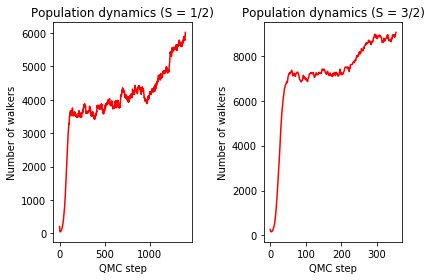

In [71]:
# Population dynamics runs
D3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=500, n_alpha=2, n_beta=1, S = 2.51, pop_dyn=True)
Q3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=500, n_alpha=3, n_beta=0, S = 4.505, pop_dyn=True)
N_max_Q = 9000
N_max_D = 6000
N_D = []
N_Q = []

print("Starting population dynamics run for the doublet state...")
while D3.get_number_of_walkers() < N_max_D:
    D3.one_time_step()
    N_D.append(D3.get_number_of_walkers())
    
    
print("Starting population dynamics run for the quartet state...")
while Q3.get_number_of_walkers() < N_max_Q:
    Q3.one_time_step()
    N_Q.append(Q3.get_number_of_walkers())

data = [('1/2', N_D), ('3/2', N_Q)]
fig, axes = plt.subplots(nrows=1, ncols=2)
for d, ax in zip(data, axes):
    spin = d[0]
    y = d[1]
    x = np.arange(len(y))
    ax.plot(x, y, 'r')
    ax.set_xlabel('QMC step')
    ax.set_ylabel('Number of walkers')
    ax.set_title('Population dynamics (S = {0})'.format(spin))

fig.tight_layout()

Based on the results of the simulations with $S = const$ one can conclude that the critical number of walkers for the states with $S = 1/2$ and $S = 3/2$ are around 4000 and 8000, respectively. If we rerun quantum Monte-Carlo simulations with the walker ensembles of the corresponding sizes, the correct energies can be obtained.

In [77]:
D3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=5000, n_alpha=2, n_beta=1, S = 2.5)
Q3 = Walker_ensemble(random_walk=rw0101, potential=V_harm, n_walkers=8000, n_alpha=3, n_beta=0, S = 4.5)

E_D = np.zeros(N_prod)
N_D = np.zeros(N_prod)

E_Q = np.zeros(N_prod)
N_Q = np.zeros(N_prod)

for i in range(N_equil):
    D3.one_time_step()
    Q3.one_time_step()

print("Number of walkers at the end of equilibration run is {0} (doublet)".format(D3.get_number_of_walkers()))
print("Number of walkers at the end of equilibration run is {0} (quartet)".format(Q3.get_number_of_walkers()))
print("Starting production runs...")

for i in range(N_prod):
    D3.one_time_step()
    Q3.one_time_step()

    E_D[i] = D3.get_energy()
    N_D[i] = D3.get_number_of_walkers()
    E_Q[i] = Q3.get_energy()
    N_Q[i] = Q3.get_number_of_walkers()
    
print("Average energy at the end of the production run (S = 1/2): {0:13.6f}".format(np.mean(E_D)))
print("Average energy at the end of the production run (S = 3/2): {0:13.6f}".format(np.mean(E_Q)))

Number of walkers at the end of equilibration run is 4945 (doublet)
Number of walkers at the end of equilibration run is 7917 (quartet)
Starting production runs...
Average energy at the end of the production run (S = 1/2):      2.499397
Average energy at the end of the production run (S = 3/2):      4.488633


In [78]:
# Timing information
print("The run took {0} s for doublet".format(D3.time['total']))
print("The run took {0} s for quartet".format(Q3.time['total']))

The run took 953.185147 s for doublet
The run took 1433.397774 s for quartet


In [79]:
print("Doublet (QMC): " + reblock(E_D))
print("Quartet (QMC): " + reblock(E_Q))

print("Doublet (Ref): {}".format(np.dot(doublet_occ, e5)))
print("Quartet (Ref): {}".format(np.dot(quartet_occ, e5)))

Optimal block: [6]
Doublet (QMC): < E > =   2.499397 +-   0.003835
Optimal block: [6]
Quartet (QMC): < E > =   4.488633 +-   0.004065
Doublet (Ref): 2.49781034531
Quartet (Ref): 4.49405367447


The doublet energy is in slightly better agreement with the exact result compared to the quartet energy. As shown below, this can be attributed to the timestep error.

In [80]:
rw01005 = Random_walk(delta=0.1, tau=0.05)
Q3_1 = Walker_ensemble(random_walk=rw01005, potential=V_harm, n_walkers=8000, n_alpha=3, n_beta=0, S = 4.5)

E_Q_1 = np.zeros(N_prod)
N_Q_1 = np.zeros(N_prod)

for i in range(N_equil):
    Q3_1.one_time_step()

print("Number of walkers at the end of equilibration run is {0} (quartet)".format(Q3_1.get_number_of_walkers()))
print("Starting production run...")

for i in range(N_prod):
    Q3_1.one_time_step()
    E_Q_1[i] = Q3_1.get_energy()
    N_Q_1[i] = Q3_1.get_number_of_walkers()
    
print("Average energy at the end of the production run (S = 3/2): {0:13.6f}".format(np.mean(E_Q_1)))

Number of walkers at the end of equilibration run is 8064 (quartet)
Starting production run...
Average energy at the end of the production run (S = 3/2):      4.491615


In [82]:
print("Quartet (QMC), tau = 0.05: " + reblock(E_Q_1))
print("Quartet (Ref): {0:9.6f}".format(np.dot(quartet_occ, e5)))

Optimal block: [5]
Quartet (QMC), tau = 0.05: < E > =   4.491615 +-   0.003630
Quartet (Ref):  4.494054
